In [1]:
#!pip install janome

import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from torch import nn, Tensor
import torch.nn.functional as F
#from torchtext.vocab import vocab
#import torchtext.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import math
import janome
from janome.tokenizer import Tokenizer
#import spacy
from collections import Counter
from torch.utils.data.sampler import SubsetRandomSampler
import time
#from torchtext.vocab import build_vocab_from_iterator
import levenshtein
import json
import pickle
from timm.scheduler import CosineLRScheduler
from nltk import bleu_score

In [2]:
import json

token_list_path = "20240512_ntt_idx_to_wakati_len.json"
with open( token_list_path, mode="r" , encoding="utf-8" ) as f:
    token_list = json.load( f )

token_list_en_path = "20240512_ntt_idx_to_word_len.json"
with open( token_list_en_path, mode="r" , encoding="utf-8" ) as f:
    token_list_en = json.load( f )

idx_list_path = "20240512_ntt_wakati_to_idx_len.json"
with open( idx_list_path, mode="r" , encoding="utf-8" ) as f:
    idx_list = json.load( f )

idx_list_en_path = "20240512_ntt_word_to_idx_len.json"
with open( idx_list_en_path, mode="r" , encoding="utf-8" ) as f:
    idx_list_en = json.load( f )
    
enc_vocab_size, dec_vocab_size = len(token_list) - 1, len(token_list_en) - 1
print(enc_vocab_size, dec_vocab_size)

184858 181274


In [3]:
a = torch.tensor( [ 0,1,2,3,4,5,6 ])

b = [ token_list[str(i.item())] for i in a ]

print( b )


d = idx_list['<pad>']

print( d )

['<blank>', '<bos>', '<eos>', '<unk>', '<mask>', '<pad>', '<len>']
5


In [4]:
# -*- coding: utf-8 -*-

#
# Pytorchで用いるDatasetの定義
#

# PytorchのDatasetモジュールをインポート
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

# 数値演算用モジュール(numpy)をインポート
import numpy as np

# sysモジュールをインポート
import sys


class SequenceDataset(Dataset):
    ''' ミニバッチデータを作成するクラス
        torch.utils.data.Datasetクラスを継承し，
        以下の関数を定義する
        __len__: 総サンプル数を出力する関数
        __getitem__: 1サンプルのデータを出力する関数
    feat_scp:  特徴量リストファイル
    label_scp: ラベルファイル
    feat_mean: 特徴量の平均値ベクトル
    feat_std:  特徴量の次元毎の標準偏差を並べたベクトル 
    pad_index: バッチ化の際にフレーム数を合わせる
               ためにpaddingする整数値
    splice:    前後(splice)フレームを特徴量を結合する
               splice=1とすると，前後1フレーム分結合
               するので次元数は3倍になる．
               splice=0の場合は何もしない
    '''
    def __init__(self, 
                 filename,
                 pad_index_j=idx_list['<pad>'],
                 pad_index_e=idx_list_en['<pad>'],
                 ):

        # 特徴量リスト，ラベルを1行ずつ
        # 読み込みながら情報を取得する
        self.pad_index_j = pad_index_j
        self.pad_index_e = pad_index_e
        #self.ens = []
        self.en_list = []
        self.en_lens = []
        #self.jps = []
        self.jp_list = []
        self.jp_lens = []
        self.num_data = 0
        with open(filename, mode='r', encoding="utf-8") as file_f:
            for line in file_f:
                line = line.replace( "\n", "" )
                # 各行をスペースで区切り，
                # リスト型の変数にする
                #print( "line:", line)
                en = line.split("\t")[1]
                #self.ens.append( en )
                #self.ens = self.ens
                en1 = en.split( ' ' )
                self.en_list.append( en1 )
                self.en_lens.append( len( en1 ) )

                jp = line.split("\t")[0]
                #self.jps.append( jp )
                #self.jps = self.jps
                jp1 = jp.split( ' ' )
                self.jp_list.append( jp1 )
                self.jp_lens.append( len( jp1 ) )
                self.num_data += 1

        self.en_lens = np.int64( np.array( self.en_lens ) )
        self.jp_lens = np.int64( np.array( self.jp_lens ) )


        # フレーム数の最大値を得る
        self.max_en_len = np.max(self.en_lens)
        # ラベル長の最大値を得る
        self.max_jp_len = np.max(self.jp_lens)

        # ラベルデータの長さを最大フレーム長に
        # 合わせるため，pad_indexの値で埋める
        for n in range(self.num_data):
            print( "n:", n )
            # 埋めるフレームの数
            # = 最大フレーム数 - 自分のフレーム数
            pad_len = self.max_en_len \
                    - self.en_lens[n]
            # pad_indexの値で埋める
            #print("n:{}".format( n ) )
            #print("len of en_list:{}".format( len( self.en_list ) ) )
            tmp = self.en_list[n]
            self.en_list[n] = np.pad( tmp, (0, pad_len), mode='constant', constant_values=(self.pad_index_e, self.pad_index_e ))
            #print( self.en_list[n][0].dtype )
            #tmp = torch.tensor( self.en_list[n] )
            #tmp = F.pad( tmp, (0, pad_len), 'constant', self.pad_index_e )
            #self.en_list[n] = tmp.to('cpu').detach().numpy().copy()
            #print( self.en_list[n] )
            #tmp = torch.tensor( self.en_list[n] )
            #if torch.any( tmp == 5785 ):
            #    print( "tmp == 5785" )
            pad_len = self.max_jp_len \
                    - self.jp_lens[n]
            # pad_indexの値で埋める
            #print("n:{}".format( n ) )
            #print("len of en_list:{}".format( len( self.en_list ) ) )
            self.jp_list[n] = np.pad(self.jp_list[n],[0, pad_len],mode='constant', constant_values=self.pad_index_j)

        self.en_list = np.int64( np.array( self.en_list ) )
        self.jp_list = np.int64( np.array( self.jp_list ) )
        #print( self.jp_list )

        #max = np.max( self.jp_list, axis =1 )
        #maxmax = np.max( max )
        #print( "maxmax:{}".format(maxmax) )


    def __len__(self):
        ''' 学習データの総サンプル数を返す関数
        本実装では発話単位でバッチを作成するため，
        総サンプル数=発話数である．
        '''
        return self.num_data


    def __getitem__(self, idx):
        ''' サンプルデータを返す関数
        本実装では発話単位でバッチを作成するため，
        idx=発話番号である．
        '''
        # 特徴量系列のフレーム数
        jp_len = self.jp_lens[idx]
        # ラベルの長さ
        en_len = self.en_lens[idx]

        # ラベル
        jp = self.jp_list[idx]
        #print( jp )
        #jp = np.fromfile(self.jp_list[idx],dtype=np.int64)

        # 発話ID
        en = self.en_list[idx]
        #ens = np.fromfile(self.en_list[idx],dtype=np.float32)

        #batch = {}
        #batch['jp'] = jp
        #batch['en'] = en
        #batch['jp_len'] = jp_len
        #batch['en_len'] = en_len


        # 特徴量，ラベル，フレーム数，
        # ラベル長，発話IDを返す
        #return (jps, jp_lens, ens,  en_lens)
        return (jp, en, jp_len, en_len )

In [5]:
BATCH_SIZE = 20
batch_size = BATCH_SIZE

#train_dataset = SequenceDataset( "20240512_ntt_ids_train_len.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )
train_dataset = SequenceDataset( "20240512_ntt_ids_dev_len.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>']  )
val_dataset = SequenceDataset( "20240512_ntt_ids_dev_len.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>']  )
    
# 訓練データのDataLoaderを呼び出す
# 訓練データはシャッフルして用いる
#  (num_workerは大きい程処理が速くなりますが，
#   PCに負担が出ます．PCのスペックに応じて
#   設定してください)

num_workers = 4 if torch.cuda.is_available() else 0

train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers)
# 開発データのDataLoaderを呼び出す
# 開発データはデータはシャッフルしない
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers)

print( len( train_loader ))
print( len( val_loader ))


text, target, text_len, target_len = next(iter(train_loader))
print(text[0], target[0], text_len[0],target_len[0], sep="\n")

n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 3754
n: 3755
n: 3756
n: 3757
n: 3758
n: 3759
n: 3760
n: 3761
n: 3762
n: 3763
n: 3764
n: 3765
n: 3766
n: 3767
n: 3768
n: 3769
n: 3770
n: 3771
n: 3772
n: 3773
n: 3774
n: 3775
n: 3776
n: 3777
n: 3778
n: 3779
n: 3780
n: 3781
n: 3782
n: 3783
n: 3784
n: 3785
n: 3786
n: 3787
n: 3788
n: 3789
n: 3790
n: 3791
n: 3792
n: 3793
n: 3794
n: 3795
n: 3796
n: 3797
n: 3798
n: 3799
n: 3800
n: 3801
n: 3802
n: 3803
n: 3804
n: 3805
n: 3806
n: 3807
n: 3808
n: 3809
n: 3810
n: 3811
n: 3812
n: 3813
n: 3814
n: 3815
n: 3816
n: 3817
n: 3818
n: 3819
n: 3820
n: 3821
n: 3822
n: 3823
n: 3824
n: 3825
n: 3826
n: 3827
n: 3828
n: 3829
n: 3830
n: 3831
n: 3832
n: 3833
n: 3834
n: 3835
n: 3836
n: 3837
n: 3838
n: 3839
n: 3840
n: 3841
n: 3842
n: 3843
n: 3844
n: 3845
n: 3846
n: 3847
n: 3848
n: 3849
n: 3850
n: 3851
n: 3852
n: 3853
n: 3854
n: 3855
n: 3856
n: 3857
n: 3858
n: 3859
n: 3860
n: 3861
n: 3862
n: 3863
n: 3864
n: 3865
n: 3866
n: 3867
n: 3868
n: 3869
n: 3870
n: 3871
n: 3872
n: 3873
n: 3874
n: 3875
n: 3876
n: 3877
n: 3878


n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 3654
n: 3655
n: 3656
n: 3657
n: 3658
n: 3659
n: 3660
n: 3661
n: 3662
n: 3663
n: 3664
n: 3665
n: 3666
n: 3667
n: 3668
n: 3669
n: 3670
n: 3671
n: 3672
n: 3673
n: 3674
n: 3675
n: 3676
n: 3677
n: 3678
n: 3679
n: 3680
n: 3681
n: 3682
n: 3683
n: 3684
n: 3685
n: 3686
n: 3687
n: 3688
n: 3689
n: 3690
n: 3691
n: 3692
n: 3693
n: 3694
n: 3695
n: 3696
n: 3697
n: 3698
n: 3699
n: 3700
n: 3701
n: 3702
n: 3703
n: 3704
n: 3705
n: 3706
n: 3707
n: 3708
n: 3709
n: 3710
n: 3711
n: 3712
n: 3713
n: 3714
n: 3715
n: 3716
n: 3717
n: 3718
n: 3719
n: 3720
n: 3721
n: 3722
n: 3723
n: 3724
n: 3725
n: 3726
n: 3727
n: 3728
n: 3729
n: 3730
n: 3731
n: 3732
n: 3733
n: 3734
n: 3735
n: 3736
n: 3737
n: 3738
n: 3739
n: 3740
n: 3741
n: 3742
n: 3743
n: 3744
n: 3745
n: 3746
n: 3747
n: 3748
n: 3749
n: 3750
n: 3751
n: 3752
n: 3753
n: 3754
n: 3755
n: 3756
n: 3757
n: 3758
n: 3759
n: 3760
n: 3761
n: 3762
n: 3763
n: 3764
n: 3765
n: 3766
n: 3767
n: 3768
n: 3769
n: 3770
n: 3771
n: 3772
n: 3773
n: 3774
n: 3775
n: 3776
n: 3777
n: 3778


250
250
tensor([   6,    1,  588,   12,  532,   72,  227,   27, 8586,   20,   22,    2,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5])
tensor([   1,   19,   14,   27,  616,   33,    7, 4135,   16,    2,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,    5,
           5,    5,    5,    5,    5,    5,    5,    5,    5,    5,

In [5]:
class PositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, max_len: int=1024):
        super().__init__()

        self.pos_emb = nn.Embedding(max_len, dim_embedding)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        positions = torch.arange(start=0, end=seq, step=1, device=x.device).to(torch.long)
        positions = self.pos_emb(positions)[:seq,:]
        
        return positions

In [6]:
class TransformerEncoder(nn.Module):
    '''
    dim_hidden     : 入力特徴量の次元
    dim_feedforward: FNNにおける中間特徴量の次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerエンコーダの層数
    '''
    def __init__(self, text_vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int,  num_layers: int, pad_index:int ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            text_vocab_size, dim_embedding, padding_idx=pad_index)        
        
        # 位置エンコーディング
        #self.positional_encoding = PositionalEncoding(dim_embedding)   
        self.pos_emb = PositionalEmbedding(dim_embedding)
        #self.pos_enc = PositionalEncoding(dim_embedding)
        self.embed_lengths = nn.Embedding(1024, dim_embedding)
        nn.init.normal_(self.embed_lengths.weight, mean=0, std=0.02)
        
        # Transformerエンコーダ層
        #self.layers = nn.ModuleList([TransformerEncoderLayer(
        #    dim_embedding, num_heads, dim_feedforward
        #) for _ in range(num_layers)])
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])


        # ロジットを生成する前のレイヤー正規化と全結合
        #self.norm = nn.LayerNorm(dim_embedding)
        #self.linear = nn.Linear( dim_embedding, 1 )
        
        self.pad_index = pad_index
        #self._reset_parameters2()
        
    #def _reset_parameters2(self):
    #    config = ConfigTrain()        
    #    for module in self.modules():
    #        if isinstance(module, nn.Linear):
    #            nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #            if module.bias is not None:
    #                nn.init.zeros_(module.bias)
    #        elif isinstance(module, nn.Embedding):
    #            #nn.init.normal_(module.weight, mean=0.0, std=0.02)
    #            module.weight = nn.Parameter( module.weight * config.alpha )
    #        elif isinstance(module, nn.LayerNorm):
    #            nn.init.zeros_(module.bias)
    #            nn.init.ones_(module.weight)

    '''
    順伝播関数
    x           : 入力, [バッチサイズ, 入力チャネル数, 高さ, 幅]
    return_embed: 特徴量を返すかロジットを返すかを選択する真偽値
    '''
    #def forward(self, x: torch.Tensor, mask: torch.Tensor=None ):
    def forward(self, x: torch.Tensor, mask_src: torch.Tensor=None, padding_mask_src: torch.Tensor=None ):

        #print("0 x size:", x.size())
        x = self.embed( x )
        #print("1 x size:", x.size())
        
        position = self.pos_emb( x )
        x = x + position
        #x = self.pos_enc( x )

        #print("2 x size:", x.size())
        
        # Transformerエンコーダ層を適用
        #for layer in self.layers:
        for layer in self.encoder_layers:
            #x = layer(x, padding_mask = mask)
            x = layer( x, src_key_padding_mask = padding_mask_src )

        #print("3 x size:", x.size())
            
        #x = self.norm(x)
        #print( "size of x[:,0,:]:",x[:,0,:].size())
        #print( "size of self.pos_emb.pos_emb.weight.tranpose(0,1):",self.pos_emb.pos_emb.weight.transpose(0,1).size())
        predicted_lengths_logits = torch.matmul( x[:,0,:], self.embed_lengths.weight.transpose(0,1)).float()
        predicted_lengths_logits [:,0] += float('-inf')
        predicted_lengths = F.log_softmax( predicted_lengths_logits, dim = -1 )
        #length = torch.squeeze( self.linear( length ), dim = 1 )
        #enc_out = torch.zeros_like( x )
        enc_out = x[:,1:,:]
        
        return enc_out, predicted_lengths

    '''
    モデルパラメータが保持されているデバイスを返す関数
    '''
    def get_device(self):
        return self.linear.weight.device

    '''
    モデルを複製して返す関数
    '''
    def copy(self):
        return copy.deepcopy(self)

In [7]:
class TransformerDecoder(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    pad_index      : PADのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, vocab_size: int, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, 
                 pad_index: int, dropout: float=0.5, us_rate: float=2.0 ):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            vocab_size, dim_embedding, padding_idx=pad_index)
        
        # 位置エンコーディング
        self.pos_emb = PositionalEmbedding(dim_embedding)
        #self.pos_enc = PositionalEncoding(dim_embedding)
        #self.positional_encoding = PositionalEncoding(dim_embedding).to( device = config.device )

        # Transformerデコーダ
        #self.decoder_layers = nn.ModuleList([
        #    TransformerDecoderLayer(
        #        dim_embedding, num_heads, dim_feedforward, dropout)
        #    for _ in range(num_layers)
        #])
        self.decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        
        
        # 単語出力分布計算
        self.linear = nn.Linear(dim_embedding, vocab_size)
        
        self.pad_index = pad_index
        self.us_rate = us_rate


    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    #def forward(self, features: torch.Tensor, caption_lengths: torch.Tensor):
    #def forward(self, features: torch.Tensor, captions: torch.Tensor, causal_mask: torch.Tensor=None, 
    #            dec_padding_mask: torch.Tensor=None, dec_input_lens: torch.Tensor=None):
    def forward(self, features: torch.Tensor, captions: torch.Tensor, padding_mask_src: torch.Tensor=None, \
                padding_mask_tgt: torch.Tensor=None, mask_tgt: torch.Tensor=None, dec_input_lens: torch.Tensor=None ):
        #feature_lengths = torch.ones( (features.size(0) ), device=features.device ) * features.size(1)

        # upsampleing
        #print( "size of embeddings:", embeddings.size())
        #captions1, padding_mask_tgt1, output_lens1 = self.upsample( captions.float().clone(), padding_mask_tgt.float().clone(), dec_input_lens.clone() )
        captions, padding_mask_tgt, output_lens = self.upsample( captions.float(), padding_mask_tgt.float(), dec_input_lens )
        
        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        #embeddings = self.embed(captions1)
        embeddings = self.embed(captions)
        seq = embeddings.shape[1]

       
        # 位置エンコーディング
        position = self.pos_emb( embeddings )
        embeddings = embeddings + position
        #embeddings = self.pos_enc(embeddings)
        
        #print( " size of embeddings:",embeddings.size())
        #print( " size of features:", features.size())
        #print( " size of causal_mask", causal_mask.size())
        #print( " size of dec_padding_mask", dec_padding_mask.size())
        
        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        #print( "size of padding_mask_tgt:", padding_mask_tgt.size())
        #print( "size of padding_mask_src:", padding_mask_src.size())
        for layer in self.decoder_layers:
            #embeddings = layer(embeddings, features, causal_mask = causal_mask, padding_mask = dec_padding_mask)
            #embeddings = layer( embeddings, features, tgt_key_padding_mask = padding_mask_tgt1, \
            embeddings = layer( embeddings, features, tgt_key_padding_mask = padding_mask_tgt, \
                               memory_key_padding_mask = padding_mask_src )

        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        preds = self.linear(embeddings)

        #return preds, output_lens1
        return preds, output_lens
    
    #def forward(self, features: torch.Tensor, caption_lengths: torch.Tensor):
    #def forward2(self, features: torch.Tensor, captions: torch.Tensor, causal_mask: torch.Tensor=None, 
    #            dec_padding_mask: torch.Tensor=None, dec_input_lens: torch.Tensor=None):
    def forward2(self, features: torch.Tensor, captions: torch.Tensor, padding_mask_src: torch.Tensor=None, \
                padding_mask_tgt: torch.Tensor=None, mask_tgt: torch.Tensor=None, dec_input_lens: torch.Tensor=None ):
        #feature_lengths = torch.ones( (features.size(0) ), device=features.device ) * features.size(1)

        # upsampleing
        #print( "size of embeddings:", embeddings.size())
        #embeddings, causal_mask, dec_padding_mask, output_lens = self.upsample( embeddings, causal_mask, dec_padding_mask, dec_input_lens )
        #print( "before size of embeddings:", embeddings.size())
        #print( "before size of causal_mask:", causal_mask.size())
        #print( "before size of dec_padding_mask:", dec_padding_mask.size())
        #_, _, _, output_lens = self.upsample( captions, causal_mask, dec_padding_mask, dec_input_lens )
        #_, padding_mask_tgt1, output_lens1 = self.upsample( captions.float().clone(), padding_mask_tgt.float().clone(), dec_input_lens.clone() )
        _, padding_mask_tgt, output_lens = self.upsample( captions.float(), padding_mask_tgt.float(), dec_input_lens )
        #print( "after size of embeddings:", embeddings.size())
        #print( "after size of causal_mask:", causal_mask.size())
        #print( "after size of dec_padding_mask:", dec_padding_mask.size())
        
        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        embeddings = self.embed(captions)
        seq = embeddings.shape[1]

        # 位置エンコーディング
        position = self.pos_emb( embeddings )
        embeddings = embeddings + position
        #embeddings = self.pos_enc(embeddings)
        
        #print( " size of embeddings:",embeddings.size())
        #print( " size of features:", features.size())
        #print( " size of causal_mask", causal_mask.size())
        #print( " size of dec_padding_mask", dec_padding_mask.size())
        
        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        for layer in self.decoder_layers:
            #embeddings = layer(embeddings, features, causal_mask = causal_mask, padding_mask = dec_padding_mask)
            #print( "padding_mask_tgt1:",padding_mask_tgt1.size())
            #print( "padding_mask_src:",padding_mask_src.size())
            #embeddings = layer( embeddings, features, tgt_key_padding_mask = padding_mask_tgt1, \
            embeddings = layer( embeddings, features, tgt_key_padding_mask = padding_mask_tgt, \
                               memory_key_padding_mask = padding_mask_src )

        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        preds = self.linear(embeddings)

        #return preds, output_lens1
        return preds, output_lens
    
    def upsample(self, dec_input, padding_mask_tgt, input_lengths ):

        max_label_length = int( round( padding_mask_tgt.size(1) * self.us_rate ) )

        polated_lengths = torch.round( torch.ones( dec_input.size(0) ) * padding_mask_tgt.size(1) * self.us_rate ).long()
        #print( "polated_lengths:", polated_lengths)

        #print( "input_lengths:", input_lengths )
        #print( "self.us_rate:", self.us_rate)
        
        outputs_lens = torch.round( input_lengths * self.us_rate ).long()

        x = torch.unsqueeze( dec_input, dim = 1 )
        #print( " size of x:", x.size())
        x2 = torch.unsqueeze( padding_mask_tgt, dim = 1 )
        #print( " size of x2:", x2.size())
            
        #print( " size of x2:", x2.size() )
        out_lens = polated_lengths

        y = torch.tensor( [], device = dec_input.device )
        y2 = torch.tensor( [], device = dec_input.device )
        
        for i in range( x.size(0) ):
            x0 = torch.unsqueeze( x[i], dim = 0 )
            #x0 = x0.permute( 0,2,1 )
            x20 = x2[i]
            x20 = torch.unsqueeze( x20, dim = 0 )
            x_out = torch.nn.functional.interpolate(x0, size = (out_lens[i]), mode='nearest-exact')
            x2_out = torch.nn.functional.interpolate(x20, size = (out_lens[i]), mode='nearest-exact')
            #print( "size of x2_out:", x2_out.size())
            z = torch.zeros( (x_out.size(0), x_out.size(1), max_label_length), device = dec_input.device )
            z2 = torch.zeros( (x2_out.size(0), x2_out.size(1), max_label_length ), device = dec_input.device )
            if z.size(2) > x_out.size(2):
                z[:,:,:x_out.size(2)] = x_out[:,:,:]
            else:
                z[:,:,:] = x_out[:,:,:z.size(2)]
            if z2.size(2) > x2_out.size(2):
                z2[:,:,:x2_out.size(2)] = x2_out[:,:,:]
            else:
                z2[:,:,:] = x2_out[:,:,:z2.size(2)]
            #print( " size of z2:", z2.size())

            x_out = z
            x2_out = z2
            y = torch.cat( [y, x_out], dim = 0)
            y2 = torch.cat( [y2, x2_out], dim = 0 )
            #print( "0 size of y2:", y2.size())
            
        y = torch.squeeze( y, dim = 1 )
        y2 = torch.squeeze( y2, dim = 1 )
        #print( "size of y2:", y2.size())
        
        return y.long(), y2.bool(), outputs_lens.to(torch.int32)



In [8]:
class Transformer(nn.Module):
    def __init__(self, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, enc_vocab_size: int, dec_vocab_size: int,
                 pad_index_e: int, pad_index_j: int, dropout: float=0.5, us_rate: float=2.0 ):
        super().__init__()

        self.encoder = TransformerEncoder(enc_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, pad_index_e )
        self.decoder = TransformerDecoder(dec_vocab_size, dim_embedding, dim_feedforward, num_heads, num_layers, pad_index_j, 0.5, us_rate )
        self.pad_index_e = pad_index_e
        self.pad_index_j = pad_index_j
        
    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]

    '''
    def forward(self, text, dec_input, dec_input_lens):

        text2 = text[:,1:]
        #print( "size of text:", text.size())
        #print( " size of text2:", text2.size())
        enc_padding_mask = torch.eq(text, self.pad_index_e).to( torch.bool )        
        dec_padding_mask = torch.eq(text2, self.pad_index_e).to( torch.bool )
        
        
        # 未来のキャプションを参照しないようにマスク行列を生成と 
        dec_target_padding_mask = torch.eq(dec_input, self.pad_index_j).to(torch.bool)
        seq = dec_input.size(1)
        #tgt_mask = torch.unsqueeze( torch.unsqueeze( torch.tril(torch.ones((seq, seq))), dim = 0 ), dim = 1 ).to( torch.float64 )
        tgt_mask = torch.zeros((seq, seq)).to( torch.bool )
        #causal_mask = torch.max(dec_target_padding_mask.to(device), tgt_mask.to(device))
        
        #print( "size of text:", text.size())
        #print( "size of enc_padding_mask:", enc_padding_mask.size())
        
        
        enc_out, length = self.encoder( text, None, enc_padding_mask )
        
        #print( "size of enc_out:", enc_out.size())
        #print( "size of dec_padding_mask:", dec_padding_mask.size() )
        
        #preds = self.decoder(enc_out,dec_input, causal_mask, dec_padding_mask)
        preds, output_lens = self.decoder(enc_out,dec_input, dec_padding_mask, dec_target_padding_mask, tgt_mask, dec_input_lens)
        #def forward(self, features: torch.Tensor, captions: torch.Tensor, padding_mask_src: torch.Tensor=None, \
        #        padding_mask_tgt: torch.Tensor=None, mask_tgt: torch.Tensor=None, dec_input_lens: torch.Tensor=None ):
        
        
        #print( "in transformer argmax of preds[0]:", torch.argmax( preds[0], dim = 1 ))
        
        return preds, length, output_lens

    def ctc_simple_inference_cap(self, dec_out):
        ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
            1. 同じ文字が連続して出現する場合は削除
            2. blank を削除
        int_vector: フレーム単位のCTC出力(整数値列)
        token_list: トークンリスト
        output:     トークン列
        '''
        caption0 = torch.argmax( dec_out, dim = 1 )
        # 出力文字列
        output = []
        # 一つ前フレームの文字番号
        prev_token = -1
        # フレーム毎の出力文字系列を前から順番にチェックしていく
        for n in caption0:
            n = n.item()
            if n != prev_token:
                # 1. 前フレームと同じトークンではない
                if n != 0:
                    # 2. かつ，blank(番号=0)ではない
                    # --> token_listから対応する文字を抽出し，
                    #     出力文字列に加える
                    output.append( n )
                    #if n == idx_list_en['<eos>']:
                    #    break
                # 前フレームのトークンを更新
                prev_token = n
            
        return output
    
    def ctc_simple_inference_prob(self, dec_out):
        ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
            1. 同じ文字が連続して出現する場合は削除
            2. blank を削除
        int_vector: フレーム単位のCTC出力(整数値列)
        token_list: トークンリスト
        output:     トークン列
        '''
        caption0 = torch.argmax( dec_out, dim = 1 )
        probability0 = torch.max( dec_out, dim = 1 ).values
        # 出力文字列
        probability = []
        # 一つ前フレームの文字番号
        prev_token = -1
        # フレーム毎の出力文字系列を前から順番にチェックしていく
        for (n, p) in zip( caption0, probability0):
            n = n.item()
            p = p.item()
            if n != prev_token:
                # 1. 前フレームと同じトークンではない
                if n != 0:
                    # 2. かつ，blank(番号=0)ではない
                    # --> token_listから対応する文字を抽出し，
                    #     出力文字列に加える
                    probability.append( p )
                    #if n == idx_list_en['<eos>']:
                    #    break
                # 前フレームのトークンを更新
                prev_token = n
            
        return probability    


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Transformer(512, 2048, 8, 6, enc_vocab_size, dec_vocab_size, idx_list_en['<pad>'],idx_list['<pad>'] ).to(device)

#criterion = nn.CrossEntropyLoss(ignore_index = idx_list_en['<pad>'])
criterion = nn.CTCLoss(blank=0, reduction='mean')  
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [10]:
'''
def rand_ints_nodup(a, b, k):
    ns = []
    while len(ns) < k:
        n = random.randint(a, b)
        if not n in ns:
            ns.append(n)
    return ns

def time_masking( dec_input, dec_input_lens ):

    mask = torch.zeros_like( dec_input ).bool()

    for n in range( dec_input.size(0) ):
        m_max = torch.randint( low = 1, high = dec_input_lens[n] + 1 , size=(1, ) )
        m = rand_ints_nodup( 0, dec_input_lens[n] - 1 , m_max )
        m =torch.tensor( m , device = dec_input.device )
        #print( "size of dec_input:", dec_input.size())
        #print( "mas of m:",torch.max( m ) )
        dec_input[n,m] = idx_list_en['<mask>']
        mask[n,m] = True
        
    return dec_input, mask
'''
def calc_length_loss( predicted_lengths, target):
    length_target = target.ne( idx_list_en['<pad>']).sum(-1).unsqueeze(-1)
    length_lprobs = predicted_lengths
    length_loss = -length_lprobs.gather( dim = -1, index=length_target)
    #length_loss = length_loss.sum()
    length_loss = length_loss.float().mean()
    return length_loss

def time_masking( dec_input, dec_input_lens ):
    
    mask = torch.zeros_like( dec_input ).bool()
    
    for n in range( dec_input.size(0) ):
        sample_size = np.random.randint( 0, dec_input_lens[n] + 1 )
        ind = np.random.choice( dec_input_lens[n], size = sample_size, replace=False)
        dec_input[n,ind]= idx_list_en['<mask>']
        mask[n,ind] = True
        
    return dec_input, mask

def ctc_simple_decode(int_vector, token_list):
    ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
        1. 同じ文字が連続して出現する場合は削除
        2. blank を削除
    int_vector: フレーム単位のCTC出力(整数値列)
    token_list: トークンリスト
    output:     トークン列
    '''
    #print( "en3:{}".format( len( token_list ) ) )
    #print( "en4:{}".format( token_list[9656] ) )
    #print( "en5:{}".format( token_list[9657] ) )
    # 出力文字列
    output = []
    # 一つ前フレームの文字番号
    prev_token = -1
    # フレーム毎の出力文字系列を前から順番にチェックしていく
    for n in int_vector:
        n = n.item()
        #print( "n:{}".format( n ) )
        #print( " n:{}".format( n ))
        #print( " prev_token:{}".format( prev_token ))
        if n != prev_token:
            # 1. 前フレームと同じトークンではない
            if n != 0:
                # 2. かつ，blank(番号=0)ではない
                # --> token_listから対応する文字を抽出し，
                #     出力文字列に加える
                #print( "n:{}".format( n ) )
                #output.append(token_list[str(n)])
                #if token_list[str(n)] != "<sos>" and token_list[str(n)] != "<eos>" and token_list[str(n)] != '.':
                #    output.append( " " + token_list[str(n)])
                #else:
                output.append( token_list[str(n)])
                if token_list_en[str(n)] == '<eos>' or token_list_en[str(n)] =='<pad>':
                    break
            # 前フレームのトークンを更新
            prev_token = n
    return output

def ctc_simple_decode2(int_vector, token_list):
    ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
        1. 同じ文字が連続して出現する場合は削除
        2. blank を削除
    int_vector: フレーム単位のCTC出力(整数値列)
    token_list: トークンリスト
    output:     トークン列
    '''
    #print( "en3:{}".format( len( token_list ) ) )
    #print( "en4:{}".format( token_list[9656] ) )
    #print( "en5:{}".format( token_list[9657] ) )
    # 出力文字列
    output = []
    # 一つ前フレームの文字番号
    prev_token = -1
    # フレーム毎の出力文字系列を前から順番にチェックしていく
    for n in int_vector:
        n = n.item()
        #print( "n:{}".format( n ) )
        #print( " n:{}".format( n ))
        #print( " prev_token:{}".format( prev_token ))
        if n != prev_token:
            # 1. 前フレームと同じトークンではない
            if n != 0:
                # 2. かつ，blank(番号=0)ではない
                # --> token_listから対応する文字を抽出し，
                #     出力文字列に加える
                #print( "n:{}".format( n ) )
                #output.append(token_list[str(n)])
                #if token_list[str(n)] != "<sos>" and token_list[str(n)] != "<eos>" and token_list[str(n)] != '.':
                #    output.append( " " + token_list[str(n)])
                #else:
                output.append( n )
                if token_list_en[str(n)] == '<eos>' or token_list_en[str(n)] =='<pad>':
                    break
            # 前フレームのトークンを更新
            prev_token = n
    return output



In [11]:
epoch_num = 20

# WarmupとCosine Decayを行うスケジューラを利用
scheduler = CosineLRScheduler(
    optimizer, t_initial=epoch_num, lr_min=1e-5,
    warmup_t=3, warmup_lr_init=5e-6, warmup_prefix=True)

tr_print_coef = 1000
#tr_print_coef = 50
val_print_coef = 50
#train_length = len(train_loader)
#train_int = train_length // tr_print_coef
#print( train_int )
#print( train_length )
#val_length = len(val_loader)
#val_int = val_length // val_print_coef
#print( val_int )
#print( val_length )

history = {"train_loss0": [], "val_loss0": [], "train_loss1":[],"train_wer": [], "train_bleu": [],\
           "val_loss1": [], "train_loss":[],   "val_loss": [],  "val_wer": [], "val_bleu": [] }

n = 0
train_loss = 0
val_loss = 0

for epoch in range(epoch_num):
    model.train()
    scheduler.step(epoch)
    print( "Train")
    total_error = 0
    total_token_length = 0
    train_loss0 = 0
    train_loss1 = 0
    train_loss = 0
    total_bleu = 0
    n = 0
    n3 = 0
    for i, ( text, target, text_len, target_len ) in enumerate(train_loader):
        optimizer.zero_grad()
        text = text[:,:max(text_len)].to(device)
        target = target[:,:max(target_len)].to(device)

        dec_input, mask = time_masking( target.clone(), target_len )
        
        outputs, length, output_lens = model(text, dec_input, target_len)
        preds = torch.argmax( outputs, dim = 2 )
        #print( "preds[0]:", preds[0])

        outputs = F.log_softmax( outputs, dim=2 )
        #output_lens = torch.full( size=(outputs.size(0),), fill_value=outputs.size(1), dtype=torch.long)
        loss0 = criterion( outputs.transpose(0, 1), target, output_lens, target_len )        
        #loss0 = criterion( outputs[mask], target[mask] )
        #loss1 = nn.MSELoss()( length.to(torch.float64 ).to(device), target_len.to(torch.float64).to(device) )
        loss1 = calc_length_loss( length, target )
        loss = loss0 + loss1
        loss.backward()
        optimizer.step()

        #acc = torch.mean( (preds == target.float()).float() )
        
        n2 = 0
        jap_sentence = []
        hypo_sentence = []
        ref_sentence = []
        for hypo_id, caption, japa in zip( preds, target, text ):
            jap = []
            for m in japa:
                jap.append( token_list[str(m.item())])
                if m == idx_list['<eos>']:
                    break
            #hypo = []
            #for m in hypo_id:
            #    hypo.append(token_list_en[str(m.item())])
            #    if m == idx_list_en['<eos>']:
            #        break
            hypo = ctc_simple_decode( hypo_id, token_list_en)
            # 正解の文字列を取得
            reference = []
            for m in caption:
                reference.append( token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break

                
            # 認識誤りを計算
            (error, substitute, 
                delete, insert, ref_length) = \
                levenshtein.calculate_error(hypo,reference)
    
            #print( "reference:", ' '.join(reference ) )
            #print( "hypo:", ' '.join(hypo))

            bleu = bleu_score.sentence_bleu( [reference], hypo )
        
            total_bleu += bleu
    
            total_error += error
            total_token_length += ref_length

            if n2 < 4 and i == len( train_loader ) -1 :
                jap_sentence.append( ''.join(jap))
                hypo_sentence.append( ' '.join(hypo) )
                ref_sentence.append( ' '.join(reference ) )
                    
            n2 += 1
            n3 += 1
                
        train_loss0 += loss0.item()
        train_loss1 += loss1.item()
        train_loss += loss.item()
        n += 1
        history["train_loss0"].append( train_loss0 / n )
        history["train_loss1"].append( train_loss1 / n )
        history["train_loss"].append( train_loss / n )
        history["train_wer"].append( total_error/total_token_length * 100)
        history["train_bleu"].append( total_bleu/ n3 * 100 )
        if i % tr_print_coef == tr_print_coef - 1:
            lr = optimizer.param_groups[0]['lr']
            print(f"epoch:{epoch+1}  index:{i+1}  loss0:{train_loss0/n:.10f} loss1:{train_loss1/n:.10f} loss:{train_loss/n:.10f} WER:{total_error / total_token_length * 100:.10f} BLEU:{total_bleu / n3 * 100 } lr:{lr:.10f}")
            #with open("history_NTT_MASK_mask2_curr.pkl", "wb") as f:
           #     pickle.dump( history, f )
        if i == len( train_loader ) - 1:
            for (hypo_s, refe_s, jap_s ) in zip( hypo_sentence, ref_sentence, jap_sentence ):
                print( "japa:", jap_s)
                print( "refe:", refe_s)
                print( "hypo:", hypo_s )

    model.eval()
    print("Eval")
    total_error = 0
    total_token_length = 0
    total_bleu = 0
    val_loss0 = 0
    val_loss1 = 0
    val_loss = 0
    n = 0
    n3 = 0
    for i, ( text, target, text_len, target_len ) in enumerate(val_loader):
        text = text[:,:max(text_len)].to(device)
        target = target[:,:max(target_len)].to(device)

        dec_input, mask = time_masking( target.clone(), target_len )
        
        with torch.no_grad():
            outputs, length, output_lens = model(text, dec_input, target_len)
            preds = torch.argmax( outputs, dim = 2 )
            #print( "preds[0]:", preds[0])

            outputs = F.log_softmax( outputs, dim=2 )
            #output_lens = torch.full( size=(outputs.size(0),), fill_value=outputs.size(1), dtype=torch.long)
            loss0 = criterion( outputs.transpose(0, 1), target, output_lens, target_len )
            #loss0 = criterion( outputs[mask], target[mask] )
            #loss1 = nn.MSELoss()( length.to(device), target_len.to(torch.float64 ).to(device) )
            #loss = loss0 + loss1
            loss1 = calc_length_loss( length, target )
            loss = loss0 + loss1

            
        preds = torch.argmax( outputs, dim = 2 )
        #acc = torch.mean( (preds == target.float()).float() )

        n2 = 0
        jap_sentence = []
        hypo_sentence = []
        ref_sentence = []
        for hypo_id, caption, japa in zip( preds, target, text ):
            jap = []
            for m in japa:
                jap.append( token_list[str(m.item())])
                if m == idx_list['<eos>']:
                    break
            #hypo = []
            #for m in hypo_id:
            #    hypo.append(token_list_en[str(m.item())])
            #    if m == idx_list_en['<eos>']:
            #        break
            hypo = ctc_simple_decode( hypo_id, token_list_en)
            # 正解の文字列を取得
            reference = []
            for m in caption:
                reference.append( token_list_en[str(m.item())])
                if m == idx_list_en['<eos>']:
                    break
                
            # 認識誤りを計算
            (error, substitute, 
                delete, insert, ref_length) = \
                levenshtein.calculate_error(hypo,reference)

            bleu = bleu_score.sentence_bleu( [reference], hypo )
        
            total_bleu += bleu
            
            total_error += error
            total_token_length += ref_length

            if n2 < 4 and i == len( val_loader ) -1 :
                jap_sentence.append( ''.join(jap))
                hypo_sentence.append( ' '.join(hypo) )
                ref_sentence.append( ' '.join(reference ) )
                    
            n2 += 1
            n3 += 1
        
        val_loss0 += loss0.item()
        val_loss1 += loss1.item()
        val_loss += loss.item()
        n += 1
        history["val_loss0"].append(val_loss0 / n )
        history["val_loss1"].append(val_loss1 / n )
        history["val_loss"].append(val_loss / n )
        history["val_wer"].append( total_error/total_token_length * 100)
        history["val_bleu"].append( total_bleu / n3 * 100 )
        if i % val_print_coef == val_print_coef - 1:
            lr = optimizer.param_groups[0]['lr']
            print(f"epoch:{epoch+1}  index:{i+1}  loss0:{val_loss0/n:.10f} loss1:{val_loss1/n:.10f} loss:{val_loss/n:.10f}   WER:{total_error / total_token_length * 100:.10f} BLEU:{total_bleu / n3 * 100 } lr:{lr:.10f}")
            PATH = './model_NTT_CTC_MASK_Meta_curr.pt'
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
                 PATH)
            with open("history_NTT_CTC_MASK_Meta_curr.pkl", "wb") as f:
                pickle.dump( history, f )
        if i == len( val_loader ) - 1:
            for (hypo_s, refe_s, jap_s ) in zip( hypo_sentence, ref_sentence, jap_sentence ):
                print( "japa:", jap_s)
                print( "refe:", refe_s)
                print( "hypo:", hypo_s )

Train


NameError: name 'train_loader' is not defined

In [ ]:
import pickle

PATH = './model_NTT_CTC_MASK_len_final_20240512.pt'

torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,},
            PATH)

with open("history_NTT_CTC_MASK_len_final_20240512.pkl", "wb") as f:
    pickle.dump( history, f )

In [34]:
#　読み込み

import pickle

PATH = "./model_NTT_CTC_MASK_Meta_curr.pt"
#PATH = "./model_NTT_MASK_mask2_curr.pt"

if torch.cuda.is_available():
    checkpoint = torch.load(PATH)
else :
    checkpoint = torch.load(PATH, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
epoch = checkpoint['epoch']
loss = checkpoint['loss']


# model.eval()2

# # - or -
model.eval()

with open('history_NTT_CTC_MASK_Meta_curr.pkl', 'rb') as f:
#with open('history_NTT_MASK_mask2_curr.pkl', 'rb') as f:
    history = pickle.load(f)

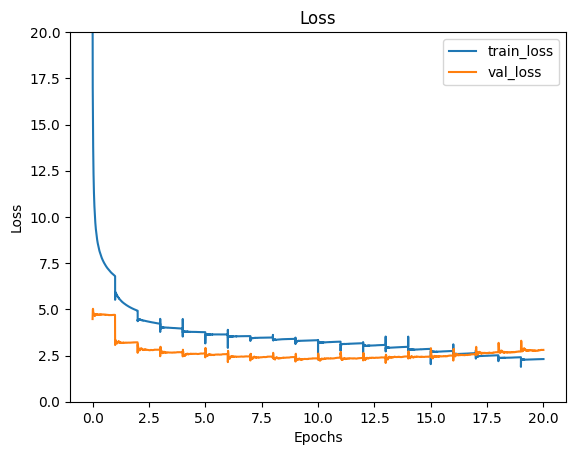

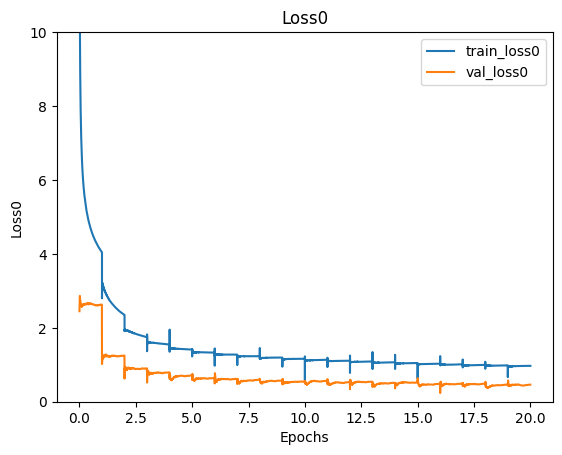

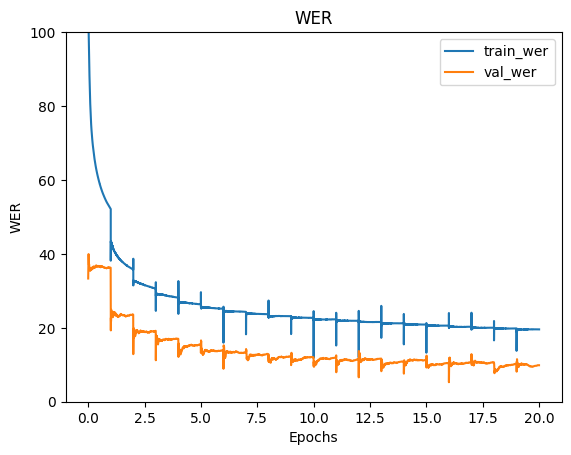

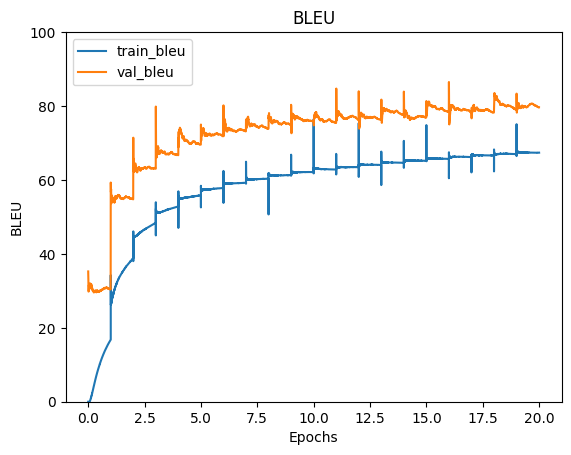

In [35]:
x = []
#print( len( history["train_loss"] ))
for i in range( len( history["train_loss"] )):
    x.append( i / 50000 )
    
v_x = []
#print( len( history["val_loss"]) )
for i in range( len( history["val_loss"]) ):
    v_x.append( i / 250 )

plt.title( "Loss")
plt.xlabel( "Epochs")
plt.ylabel( "Loss")
plt.plot(x, history["train_loss"], label="train_loss")
plt.plot( v_x, history["val_loss"], label="val_loss")
plt.ylim( 0, 20 )
plt.legend()
plt.show()

plt.title( "Loss0")
plt.xlabel( "Epochs")
plt.ylabel( "Loss0")
plt.plot(x, history["train_loss0"], label="train_loss0")
plt.plot( v_x, history["val_loss0"], label="val_loss0")
plt.ylim( 0, 10 )
plt.legend()
plt.show()

plt.title( "WER")
plt.xlabel( "Epochs")
plt.ylabel( "WER")
plt.plot(x, history["train_wer"], label="train_wer")
plt.plot( v_x, history["val_wer"], label="val_wer")
plt.ylim( 0, 100 )
plt.legend()
plt.show()

plt.title( "BLEU")
plt.xlabel( "Epochs")
plt.ylabel( "BLEU")
plt.plot(x, history["train_bleu"], label="train_bleu")
plt.plot( v_x, history["val_bleu"], label="val_bleu")
plt.ylim( 0, 100 )
plt.legend()
plt.show()

In [36]:
def duplicate_encoder_out(encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask, bsz, beam_size):
    encoder_out = encoder_out.unsqueeze(1).repeat(1, beam_size, 1, 1 ).view( bsz * beam_size, encoder_out.size(1), encoder_out.size(2))
    if encoder_padding_mask is not None:
        encoder_padding_mask = encoder_padding_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
    if decoder_padding_mask is not None:
        decoder_padding_mask = decoder_padding_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
    if causal_mask is not None:
        causal_mask = causal_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )

    return encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask    
        
def predict_length_beam(gold_target_len, predicted_lengths, length_beam_size):
    if gold_target_len is not None:
        beam_starts = gold_target_len - (length_beam_size - 1) // 2
        beam_ends = gold_target_len + length_beam_size // 2 + 1
        beam = torch.stack([torch.arange(beam_starts[batch], beam_ends[batch], device=beam_starts.device) for batch in range(gold_target_len.size(0))], dim=0)
    else:
        beam = predicted_lengths.topk(length_beam_size, dim=1)[1]
    beam[beam < 2] = 2
    return beam

def outputs_to_tgt_tokens( outputs, max_length0, device ):
    
    tgt_tokens0 = []
    token_probs0 = []
    for output in outputs:
        tgt_tokens0.append( model.ctc_simple_inference_cap( output ) ) # n * lengths
        token_probs0.append( model.ctc_simple_inference_prob( output ) )  # n * lengths

    tgt_tokens_np = np.ones( ( outputs.size(0), max_length0 )) * idx_list_en['<pad>']
    token_probs_np = np.ones( ( outputs.size(0), max_length0 ))
            
    for n in range( outputs.size(0) ):
        if len( tgt_tokens0[n] ) <= max_length0:
            tgt_tokens_np[n,:len(tgt_tokens0[n])] = tgt_tokens0[n][:]
            token_probs_np[n,:len(tgt_tokens0[n])] = token_probs0[n][:]
        else:
            tgt_tokens_np[n,:] = tgt_tokens0[n][:max_length0]
            token_probs_np[n,:] = token_probs0[n][:max_length0]
            
    tgt_tokens = torch.tensor( tgt_tokens_np, device = device )
    token_probs = torch.tensor( ( token_probs_np ), device = device  )

    return tgt_tokens, token_probs


# 推論モジュール
@torch.no_grad()
def inference(
            text, is_inference = True
            ):
    ''' ネットワーク計算(forward処理)の関数
    input_sequence: 各発話の入力系列 [B x Tin x D]
    input_lengths:  各発話の系列長(フレーム数) [B]
        []の中はテンソルのサイズ
        B:    ミニバッチ内の発話数(ミニバッチサイズ)
        Tin:  入力テンソルの系列長(ゼロ埋め部分含む)
        D:    入力次元数(dim_in)
        Tout: 正解ラベル系列の系列長(ゼロ埋め部分含む)
    '''
    enc_padding_mask = torch.eq(text, idx_list['<pad>']).to( torch.float64 )
    enc_outs, lengths = model.encoder( text, None, enc_padding_mask )
    length_beam_size = 2
    beam = predict_length_beam( None, lengths, length_beam_size)
    max_len = beam.max().item()
    max_length0 = max_len
    bsz = enc_outs.size(0)
    src_tokens = text
    
    length_mask = torch.triu( src_tokens.new( max_len,max_len).fill_(1).long(),1 )
    length_mask = torch.stack([length_mask[beam[batch] - 1 ] for batch in range(bsz)], dim = 0)
    tgt_tokens = src_tokens.new( bsz, length_beam_size, max_len ).fill_(idx_list_en['<mask>'])
    tgt_tokens = ( 1 - length_mask ) * tgt_tokens + length_mask * idx_list_en['<pad>']
    tgt_tokens = tgt_tokens.view( bsz * length_beam_size, max_len )
    tmp_mask = torch.sum( tgt_tokens.eq( idx_list_en['<mask>']), dim = 1 )
    tmp_pad = torch.sum( tgt_tokens.eq( idx_list_en['<pad>']), dim = 1 )
    
    def select_worst(token_probs, num_mask):
        bsz, seq_len = token_probs.size()
        masks = [token_probs[batch, :].topk(max(1, num_mask[batch]), largest=False, sorted=False)[1] for batch in range(bsz)]
        masks = [torch.cat([mask, mask.new(seq_len - mask.size(0)).fill_(mask[0])], dim=0) for mask in masks]
        return torch.stack(masks, dim=0)             

    def assign_single_value_long(x, i, y):
        b, l = x.size()
        i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
        x.view(-1)[i.view(-1)] = y
        return x

    def assign_single_value_byte(x, i, y):
        x.view(-1)[i.view(-1).nonzero()] = y
        return x
    
    def assign_multi_value_long(x, i, y):
        b, l = x.size()
        i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
        x.view(-1)[i.view(-1)] = y.view(-1)[i.view(-1)]
        return x
    
    encoder_out = enc_outs
    encoder_padding_mask = torch.eq(text, idx_list['<pad>']).to( torch.float64 )         
    text2 = text[:,1:]
    decoder_padding_mask = torch.eq(text2, idx_list['<pad>']).to( torch.float64 )         
    decoder_target_padding_mask = torch.eq(tgt_tokens, idx_list_en['<pad>']).to(torch.float64)
    causal_mask = torch.zeros( ( tgt_tokens.shape[1], tgt_tokens.shape[1] ) ).bool()
    
    encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask = duplicate_encoder_out( encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask, bsz, length_beam_size)        
    
    bsz, seq_len = tgt_tokens.size()
    pad_mask = tgt_tokens.eq(idx_list_en['<pad>'])
    seq_lens = seq_len - pad_mask.sum(dim=1)
    
    iter_max = 10

    dec_out, us_lens = model.decoder(encoder_out, tgt_tokens.long(), decoder_padding_mask.bool(), decoder_target_padding_mask.bool(), causal_mask.bool(), dec_input_lens = beam )
    outputs = torch.nn.functional.softmax( dec_out, dim = 2 )

    tgt_tokens, token_probs = outputs_to_tgt_tokens( outputs, max_length0, encoder_out.device )
    
    tgt_tokens = assign_single_value_byte(tgt_tokens, pad_mask, idx_list_en['<pad>'] )
    token_probs = assign_single_value_byte(token_probs, pad_mask, 1.0)
    
    for counter in range( 1, iter_max ):
        num_mask = ( seq_lens.float() * ( 1.0 - ( counter / iter_max))).long()

        token_probs = assign_single_value_byte(token_probs, pad_mask, 1.0)
        mask_ind = select_worst(token_probs, num_mask)

        tgt_tokens = assign_single_value_long(tgt_tokens, mask_ind, idx_list_en['<mask>'])
        tgt_tokens = assign_single_value_byte(tgt_tokens, pad_mask, idx_list_en['<pad>'])    

        dec_out, us_lens = model.decoder(encoder_out, tgt_tokens.long(), decoder_padding_mask.bool(), decoder_target_padding_mask.bool(), causal_mask.bool(), dec_input_lens = beam )
        outputs = torch.nn.functional.softmax( dec_out, dim = 2 )

        new_tgt_tokens, new_token_probs = outputs_to_tgt_tokens( outputs, max_length0, encoder_out.device )

        token_probs = assign_multi_value_long(token_probs, mask_ind, new_token_probs)
        token_probs = assign_single_value_byte(token_probs, pad_mask, 1.0)
            
        tgt_tokens = assign_multi_value_long(tgt_tokens, mask_ind, new_tgt_tokens)
        tgt_tokens = assign_single_value_byte(tgt_tokens, pad_mask, idx_list_en['<pad>'])
        
    lprobs = token_probs.log().sum(-1)

    return tgt_tokens, lprobs, max_len, length_mask

In [37]:
def upsample1(tgt_tokens, token_probs, mask_ind, pad_mask ):

    us_rate = 2.0
    
    max_label_length = int( round( tgt_tokens.size(1) * us_rate ) )

    polated_lengths = torch.round( torch.ones( tgt_tokens.size(0) ) * tgt_tokens.size(1) * us_rate ).long()

    x = torch.unsqueeze( tgt_tokens, dim = 1 )
    x2 = torch.unsqueeze( token_probs, dim = 1 )
    x3 = torch.unsqueeze( mask_ind, dim = 1 )
    x4 = torch.unsqueeze( pad_mask, dim = 1 )
    out_lens = polated_lengths

    y = torch.tensor( [], device = tgt_tokens.device )
    y2 = torch.tensor( [], device = tgt_tokens.device )
    y3 = torch.tensor( [], device = tgt_tokens.device )
    y4 = torch.tensor( [], device = tgt_tokens.device)    

    for i in range( x.size(0) ):
        x0 = torch.unsqueeze( x[i], dim = 0 )
        x20 = torch.unsqueeze( x2[i], dim = 0 )
        x30 = torch.unsqueeze( x3[i], dim = 0 )
        x40 = torch.unsqueeze( x4[i], dim = 0 )
        x_out = torch.nn.functional.interpolate(x0, size = (out_lens[i]), mode='nearest-exact')
        x2_out = torch.nn.functional.interpolate(x20, size = (out_lens[i]), mode='nearest-exact')
        x3_out = torch.nn.functional.interpolate(x30, size = (out_lens[i]), mode='nearest-exact')
        x4_out = torch.nn.functional.interpolate(x40, size = (out_lens[i]), mode='nearest-exact')
        z = torch.zeros( (x_out.size(0), x_out.size(1), max_label_length), device = y.device )
        z2 = torch.zeros( (x2_out.size(0), x2_out.size(1), max_label_length), device = y.device )
        z3 = torch.zeros( (x3_out.size(0), x3_out.size(1), max_label_length), device = y.device )
        z4 = torch.zeros( (x4_out.size(0), x4_out.size(1), max_label_length), device = y.device )
        if z.size(2) > x_out.size(2):
            z[:,:,:x_out.size(2)] = x_out[:,:,:]
        else:
            z[:,:,:] = x_out[:,:,:z.size(2)]
        if z2.size(2) > x2_out.size(2):
            z2[:,:,:x2_out.size(2)] = x2_out[:,:,:]
        else:
            z2[:,:,:] = x2_out[:,:,:z2.size(2)]
        if z3.size(2) > x3_out.size(2):
            z3[:,:,:x3_out.size(2)] = x3_out[:,:,:]
        else:
            z3[:,:,:] = x3_out[:,:,:z3.size(2)]
        if z4.size(2) > x4_out.size(2):
            z4[:,:,:x4_out.size(2)] = x4_out[:,:,:]
        else:
            z4[:,:,:] = x4_out[:,:,:z4.size(2)]
            
        x_out = z
        x2_out = z2
        x3_out = z3
        x4_out = z4
        y = torch.cat( [y, x_out], dim = 0)
        y2 = torch.cat( [y2, x2_out], dim = 0 )
        y3 = torch.cat( [y3, x3_out], dim = 0 )
        y4 = torch.cat( [y4, x4_out], dim = 0 )

    y = torch.squeeze( y, dim =  1 )    
    y2 = torch.squeeze( y2, dim =  1 )    
    y3 = torch.squeeze( y3, dim =  1 )    
    y4 = torch.squeeze( y4, dim =  1 )    

    return y.long(), y2.long(), y3.bool(), y4.bool()

In [38]:
def duplicate_encoder_out(encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask, bsz, beam_size):
    encoder_out = encoder_out.unsqueeze(1).repeat(1, beam_size, 1, 1 ).view( bsz * beam_size, encoder_out.size(1), encoder_out.size(2))
    if encoder_padding_mask is not None:
        encoder_padding_mask = encoder_padding_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
    if decoder_padding_mask is not None:
        decoder_padding_mask = decoder_padding_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
    if causal_mask is not None:
        causal_mask = causal_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )

    return encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask    
        
def predict_length_beam(gold_target_len, predicted_lengths, length_beam_size):
    if gold_target_len is not None:
        beam_starts = gold_target_len - (length_beam_size - 1) // 2
        beam_ends = gold_target_len + length_beam_size // 2 + 1
        beam = torch.stack([torch.arange(beam_starts[batch], beam_ends[batch], device=beam_starts.device) for batch in range(gold_target_len.size(0))], dim=0)
    else:
        beam = predicted_lengths.topk(length_beam_size, dim=1)[1]
    beam[beam < 2] = 2
    return beam

def outputs_to_tgt_tokens( outputs, max_length0, device ):
    
    tgt_tokens0 = []
    token_probs0 = []

    for output in outputs:
        tgt_tokens0.append( model.ctc_simple_inference_cap( output ) ) # n * lengths
        token_probs0.append( model.ctc_simple_inference_prob( output ) )  # n * lengths

    tgt_tokens_np = np.ones( ( outputs.size(0), max_length0 )) * idx_list_en['<pad>']
    token_probs_np = np.ones( ( outputs.size(0), max_length0 ))
            
    for n in range( outputs.size(0) ):
        if len( tgt_tokens0[n] ) <= max_length0:
            tgt_tokens_np[n,:len(tgt_tokens0[n])] = tgt_tokens0[n][:]
            token_probs_np[n,:len(tgt_tokens0[n])] = token_probs0[n][:]
        else:
            tgt_tokens_np[n,:] = tgt_tokens0[n][:max_length0]
            token_probs_np[n,:] = token_probs0[n][:max_length0]
            
    tgt_tokens = torch.tensor( tgt_tokens_np, device = device )
    token_probs = torch.tensor( ( token_probs_np ), device = device  )

    return tgt_tokens, token_probs

# 推論モジュール
@torch.no_grad()
def inference1(
            text, is_inference = True
            ):
    ''' ネットワーク計算(forward処理)の関数
    input_sequence: 各発話の入力系列 [B x Tin x D]
    input_lengths:  各発話の系列長(フレーム数) [B]
        []の中はテンソルのサイズ
        B:    ミニバッチ内の発話数(ミニバッチサイズ)
        Tin:  入力テンソルの系列長(ゼロ埋め部分含む)
        D:    入力次元数(dim_in)
        Tout: 正解ラベル系列の系列長(ゼロ埋め部分含む)
    '''
    enc_padding_mask = torch.eq(text, idx_list['<pad>']).to( torch.bool )        
    enc_outs, lengths = model.encoder( text, None, enc_padding_mask )

    length_beam_size = 2
    beam = predict_length_beam( None, lengths, length_beam_size)
    max_len = beam.max().item()
    max_length0 = max_len
    bsz = enc_outs.size(0)
    src_tokens = text
    
    length_mask = torch.triu( src_tokens.new( max_len,max_len).fill_(1).long(),1 )
    length_mask = torch.stack([length_mask[beam[batch] - 1 ] for batch in range(bsz)], dim = 0)
    tgt_tokens = src_tokens.new( bsz, length_beam_size, max_len ).fill_(idx_list_en['<mask>'])
    tgt_tokens = ( 1 - length_mask ) * tgt_tokens + length_mask * idx_list_en['<pad>']
    tgt_tokens = tgt_tokens.view( bsz * length_beam_size, max_len )
    tmp_mask = torch.sum( tgt_tokens.eq( idx_list_en['<mask>']), dim = 1 )
    tmp_pad = torch.sum( tgt_tokens.eq( idx_list_en['<pad>']), dim = 1 )
    
    def select_worst(token_probs, num_mask):
        bsz, seq_len = token_probs.size()
        masks = [token_probs[batch, :].topk(max(1, num_mask[batch]), largest=False, sorted=False)[1] for batch in range(bsz)]
        masks = [torch.cat([mask, mask.new(seq_len - mask.size(0)).fill_(mask[0])], dim=0) for mask in masks]
        return torch.stack(masks, dim=0)             

    def assign_single_value_long(x, i, y):
        b, l = x.size()
        i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
        x.view(-1)[i.view(-1)] = y
        return x

    def assign_single_value_byte(x, i, y):
        x.view(-1)[i.view(-1).nonzero()] = y
        return x
    
    def assign_multi_value_long(x, i, y):
        b, l = x.size()
        i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
        x.view(-1)[i.view(-1)] = y.view(-1)[i.view(-1)]
        return x
    
    encoder_out = enc_outs
    encoder_padding_mask = torch.eq(text, idx_list['<pad>']).to( torch.float64 )         
    text2 = text[:,1:]
    decoder_padding_mask = torch.eq(text2, idx_list['<pad>']).to( torch.float64 )         
    decoder_target_padding_mask = torch.eq(tgt_tokens, idx_list_en['<pad>']).to(torch.float64)
    causal_mask = torch.zeros( ( tgt_tokens.shape[1], tgt_tokens.shape[1] ) ).bool()
    
    encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask = duplicate_encoder_out( encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask, bsz, length_beam_size)        
    
    bsz, seq_len = tgt_tokens.size()
    pad_mask = tgt_tokens.eq(idx_list_en['<pad>'])
    seq_lens = seq_len - pad_mask.sum(dim=1)
    
    iter_max = 10

    dec_out, us_lens = model.decoder(encoder_out, tgt_tokens.long(), decoder_padding_mask.bool(), decoder_target_padding_mask.bool(), causal_mask.bool(), dec_input_lens = beam )
    outputs = torch.nn.functional.softmax( dec_out, dim = 2 )
    upsampled_tgt_tokens = torch.argmax( outputs, dim = 2 )
    upsampled_token_probs = torch.max( outputs, dim = 2 )[1]

    _, _, _, upsampled_pad_mask = upsample1( pad_mask.float(), pad_mask.float(), pad_mask.float(), pad_mask.float() )
    
    upsampled_tgt_tokens = assign_single_value_byte(upsampled_tgt_tokens, upsampled_pad_mask, idx_list_en['<pad>'] )
    upsampled_token_probs = assign_single_value_byte(upsampled_token_probs, upsampled_pad_mask, 1.0)
    
    for counter in range( 1, iter_max ):
        num_mask = ( seq_lens.float() * ( 1.0 - ( counter / iter_max))).long() * 2

        upsampled_token_probs = assign_single_value_byte(upsampled_token_probs, upsampled_pad_mask, 1.0)
        upsampled_mask_ind = select_worst(upsampled_token_probs, num_mask)
        
        upsampled_tgt_tokens = assign_single_value_long(upsampled_tgt_tokens, upsampled_mask_ind, idx_list_en['<mask>'])
        upsampled_tgt_tokens = assign_single_value_byte(upsampled_tgt_tokens, upsampled_pad_mask, idx_list_en['<pad>'])    
        
        dec_out, us_lens = model.decoder.forward2(encoder_out, upsampled_tgt_tokens.long(), decoder_padding_mask.bool(), decoder_target_padding_mask.bool(), causal_mask.bool(), dec_input_lens = beam )
        outputs = torch.nn.functional.softmax( dec_out, dim = 2 )
        
        upsampled_new_token_probs = torch.max( outputs, dim = 2 )[1]
        upsampled_new_tgt_tokens = torch.argmax( outputs, dim = 2 )

        upsampled_token_probs = assign_multi_value_long(upsampled_token_probs, upsampled_mask_ind, upsampled_new_token_probs)
        upsampled_token_probs = assign_single_value_byte(upsampled_token_probs, upsampled_pad_mask, 1.0)
            
        upsampled_tgt_tokens = assign_multi_value_long(upsampled_tgt_tokens, upsampled_mask_ind, upsampled_new_tgt_tokens)
        upsampled_tgt_tokens = assign_single_value_byte(upsampled_tgt_tokens, upsampled_pad_mask, idx_list_en['<pad>'])

    tgt_tokens, token_probs = outputs_to_tgt_tokens( outputs, max_length0, encoder_out.device )
    lprobs = token_probs.log().sum(-1)

    #return dec_out, lprobs
    return tgt_tokens, lprobs, max_len, length_mask

In [39]:
def duplicate_encoder_out(encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask, bsz, beam_size):
    #print( "beam_size:", beam_size)
    encoder_out = encoder_out.unsqueeze(1).repeat(1, beam_size, 1, 1 ).view( bsz * beam_size, encoder_out.size(1), encoder_out.size(2))
    #print( "0 size of encoder_out:", encoder_out.size())
    if encoder_padding_mask is not None:
        encoder_padding_mask = encoder_padding_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
    if decoder_padding_mask is not None:
        decoder_padding_mask = decoder_padding_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )
    if causal_mask is not None:
        causal_mask = causal_mask.unsqueeze(1).repeat(1,beam_size,1).view(bsz * beam_size, -1 )

    return encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask    
        
def predict_length_beam(gold_target_len, predicted_lengths, length_beam_size):
    if gold_target_len is not None:
        beam_starts = gold_target_len - (length_beam_size - 1) // 2
        beam_ends = gold_target_len + length_beam_size // 2 + 1
        beam = torch.stack([torch.arange(beam_starts[batch], beam_ends[batch], device=beam_starts.device) for batch in range(gold_target_len.size(0))], dim=0)
    else:
        beam = predicted_lengths.topk(length_beam_size, dim=1)[1]
    beam[beam < 2] = 2
    return beam

def outputs_to_tgt_tokens( outputs, max_length0, device ):
    
    tgt_tokens0 = []
    token_probs0 = []
    #n = 0;
    #print( "size of outpus:", outputs.size() )
    #print( "argmax of outputs[0]:", torch.argmax( outputs[0], dim = 1 ))
    for output in outputs:
        #print( "1", model.ctc_simple_inference_cap( output ))
        tgt_tokens0.append( model.ctc_simple_inference_cap( output ) ) # n * lengths
        #print("n:" , n,  " len of tgt_tokens0:", len(tgt_tokens0[0] ))
        #n += 1
        token_probs0.append( model.ctc_simple_inference_prob( output ) )  # n * lengths

    #n = 0
    #print( "0 n:", n, "len of tgt_tokens0[n]", len( tgt_tokens0[n]))                
                
    tgt_tokens_np = np.ones( ( outputs.size(0), max_length0 )) * idx_list_en['<pad>']
    token_probs_np = np.ones( ( outputs.size(0), max_length0 ))
            
    #print( "shpae of tgt_tokens_np:", tgt_tokens_np.shape)
            
    for n in range( outputs.size(0) ):
        #print( "n:", n, "len of tgt_tokens0[n]", len( tgt_tokens0[n]))
        if len( tgt_tokens0[n] ) <= max_length0:
            tgt_tokens_np[n,:len(tgt_tokens0[n])] = tgt_tokens0[n][:]
            token_probs_np[n,:len(tgt_tokens0[n])] = token_probs0[n][:]
        else:
            tgt_tokens_np[n,:] = tgt_tokens0[n][:max_length0]
            token_probs_np[n,:] = token_probs0[n][:max_length0]
            
    tgt_tokens = torch.tensor( tgt_tokens_np, device = device )
    token_probs = torch.tensor( ( token_probs_np ), device = device  )

    return tgt_tokens, token_probs

# 修正
#null_index =  j_v.get_stoi()['<pad>']
#max_length = 20

# 推論モジュール
@torch.no_grad()
def inference2(
            text, is_inference = True
            ):
    ''' ネットワーク計算(forward処理)の関数
    input_sequence: 各発話の入力系列 [B x Tin x D]
    input_lengths:  各発話の系列長(フレーム数) [B]
        []の中はテンソルのサイズ
        B:    ミニバッチ内の発話数(ミニバッチサイズ)
        Tin:  入力テンソルの系列長(ゼロ埋め部分含む)
        D:    入力次元数(dim_in)
        Tout: 正解ラベル系列の系列長(ゼロ埋め部分含む)
    '''
    #text2 = text[:,1:]
    enc_padding_mask = torch.eq(text, idx_list['<pad>']).to( torch.bool )            
    #dec_padding_mask = torch.unsqueeze( torch.unsqueeze( torch.eq(text2, idx_list['<pad>']), dim = 1), dim = 2 ).to( torch.float64 )
    enc_outs, lengths = model.encoder( text, None, enc_padding_mask )
    #print( "size of lengths:", lengths.size() )
    '''
    lengths = torch.clamp( lengths, min=3.0 ).long()
    max_length0 = max( lengths )
    length_beam_size = 3
    max_len = max_length0 + length_beam_size
    max_length0 = max_length0 + length_beam_size
    bsz = enc_outs.size(0)
    #print( "bsz:",bsz)
    #if max_len <= bsz:
    #    max_len = bsz
    #print( "max_len:", max_len )
    src_tokens = text
    '''
    length_beam_size = 2
    beam = predict_length_beam( None, lengths, length_beam_size)
    #print( "beam:",beam.long())
    max_len = beam.max().item()
    #max_len = 29
    max_length0 = max_len
    bsz = enc_outs.size(0)
    src_tokens = text
    
    length_mask = torch.triu( src_tokens.new( max_len,max_len).fill_(1).long(),1 )
    length_mask = torch.stack([length_mask[beam[batch] - 1 ] for batch in range(bsz)], dim = 0)
    tgt_tokens = src_tokens.new( bsz, length_beam_size, max_len ).fill_(idx_list_en['<mask>'])
    tgt_tokens = ( 1 - length_mask ) * tgt_tokens + length_mask * idx_list_en['<pad>']
    tgt_tokens = tgt_tokens.view( bsz * length_beam_size, max_len )
    tmp_mask = torch.sum( tgt_tokens.eq( idx_list_en['<mask>']), dim = 1 )
    #print( "len mask:", tmp_mask )
    tmp_pad = torch.sum( tgt_tokens.eq( idx_list_en['<pad>']), dim = 1 )
    #print( "len pad:", tmp_pad )
    #print( "sum:", tmp_mask + tmp_pad)
    
    def select_worst(token_probs, num_mask):
        bsz, seq_len = token_probs.size()
        masks = [token_probs[batch, :].topk(max(1, num_mask[batch]), largest=False, sorted=False)[1] for batch in range(bsz)]
        masks = [torch.cat([mask, mask.new(seq_len - mask.size(0)).fill_(mask[0])], dim=0) for mask in masks]
        return torch.stack(masks, dim=0)             

    def assign_single_value_long(x, i, y):
        b, l = x.size()
        i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
        x.view(-1)[i.view(-1)] = y
        return x

    def assign_single_value_byte(x, i, y):
        x.view(-1)[i.view(-1).nonzero()] = y
        return x
    
    def assign_multi_value_long(x, i, y):
        b, l = x.size()
        i = i + torch.arange(0, b*l, l, device=i.device).unsqueeze(1)
        x.view(-1)[i.view(-1)] = y.view(-1)[i.view(-1)]
        return x
    
    encoder_out = enc_outs
    encoder_padding_mask = torch.eq(text, idx_list['<pad>']).to( torch.float64 )         
    text2 = text[:,1:]
    decoder_padding_mask = torch.eq(text2, idx_list['<pad>']).to( torch.float64 )         
    decoder_target_padding_mask = torch.eq(tgt_tokens, idx_list_en['<pad>']).to(torch.float64)
    #causal_mask = decoder_target_padding_mask
    #causal_mask = nn.Transformer.generate_square_subsequent_mask( tgt_tokens.shape[1] ).to(device)
    causal_mask = torch.zeros( ( tgt_tokens.shape[1], tgt_tokens.shape[1] ) ).bool()
    #print( "size of encoder_padding_mask:", encoder_padding_mask.size())
    #print( "size of decoder_padding_mask:", decoder_padding_mask.size())
    #print( "size of causal_mask:", causal_mask.size())
    
    encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask = duplicate_encoder_out( encoder_out, encoder_padding_mask, decoder_padding_mask, causal_mask, bsz, length_beam_size)        
    #enc_padding_mask = torch.unsqueeze( torch.unsqueeze( encoder_padding_mask, dim = 1), dim = 2 )
    #dec_padding_mask = torch.unsqueeze( torch.unsqueeze( decoder_padding_mask, dim = 1), dim = 2 )
    #causal_mask = torch.unsqueeze( torch.unsqueeze( causal_mask, dim = 1), dim = 2 )
    #print( "size of encoder_padding_mask:", encoder_padding_mask.size())
    #print( "size of decoder_padding_mask:", decoder_padding_mask.size())
    #print( "size of causal_mask:", causal_mask.size())
                                               
        
    #pad_mask = tgt_tokens.eq(idx_list_en['<pad>'])
    
    bsz, seq_len = tgt_tokens.size()
    pad_mask = tgt_tokens.eq(idx_list_en['<pad>'])
    seq_lens = seq_len - pad_mask.sum(dim=1)
    
    iter_max = 10

    #print( "-2 tgt_tokens:", tgt_tokens.long() )    
    #print( "size of tgt_tokens:", tgt_tokens.size())
    #print( "size of causal_mask:", causal_mask.size())
    #print( "size of decoder_padding_mask:", decoder_padding_mask.size())
    #dec_out, us_lens = model.decoder(encoder_out, tgt_tokens.long(), causal_mask = causal_mask, dec_padding_mask = dec_padding_mask, dec_input_lens = beam )
    dec_out, us_lens = model.decoder(encoder_out, tgt_tokens.long(), decoder_padding_mask.bool(), decoder_target_padding_mask.bool(), causal_mask.bool(), dec_input_lens = beam )
    outputs = torch.nn.functional.softmax( dec_out, dim = 2 )
    upsampled_tgt_tokens = torch.argmax( outputs, dim = 2 )
    upsampled_token_probs = torch.max( outputs, dim = 2 )[1]

    #tgt_tokens, token_probs = outputs_to_tgt_tokens( outputs, max_length0, encoder_out.device )
    
    #print( "-1 tgt_tokens:", tgt_tokens.long() )    
    
    _, _, _, upsampled_pad_mask = upsample1( pad_mask.float(), pad_mask.float(), pad_mask.float(), pad_mask.float() )
    
    upsampled_tgt_tokens = assign_single_value_byte(upsampled_tgt_tokens, upsampled_pad_mask, idx_list_en['<pad>'] )
    upsampled_token_probs = assign_single_value_byte(upsampled_token_probs, upsampled_pad_mask, 1.0)
    
    #print( "0 tgt_tokens:", tgt_tokens.long() )
    
    for counter in range( 1, iter_max ):
        num_mask = ( seq_lens.float() * ( 1.0 - ( counter / iter_max))).long() * 2
        #print( "num_mask:", num_mask)
        #num_mask = num_mask.unsqueeze(1).repeat(1, length_beam_size ).view( -1 )

        upsampled_token_probs = assign_single_value_byte(upsampled_token_probs, upsampled_pad_mask, 1.0)
        upsampled_mask_ind = select_worst(upsampled_token_probs, num_mask)

        #print("size of tgt_tokens:", tgt_tokens.size())
        #print("size of token_progs:", token_probs.size())
        #print("size of mask_ind:", mask_ind.size())
        
        # mask と pad が連続すると、あとの decode で一個にしてしまうから、このプログラムはダメ。
        upsampled_tgt_tokens = assign_single_value_long(upsampled_tgt_tokens, upsampled_mask_ind, idx_list_en['<mask>'])
        upsampled_tgt_tokens = assign_single_value_byte(upsampled_tgt_tokens, upsampled_pad_mask, idx_list_en['<pad>'])    
        #token_probs = assign_single_value_byte(token_probs, pad_mask, 1.0 )

        #print( "1 tgt_tokens:", tgt_tokens.long() )
        #print( "size of upsampled_tgt_tokens:", upsampled_tgt_tokens.size())
        #print( "size of causal_mask:", causal_mask.size())
        #print( "size of dec_padding_mask:", dec_padding_mask.size())
        
        
        #dec_out, us_lens = model.decoder.forward2(encoder_out, upsampled_tgt_tokens.long(), causal_mask = causal_mask, dec_padding_mask = dec_padding_mask, dec_input_lens = beam )
        #print( "size of upsampled_tgt_tokens:", upsampled_tgt_tokens.size() )
        # upsampled_tgt_tokens をデコードする
        tgt_tokens0 = []
        #max_tmp1 = 0
        for upsampled_tgt_tokens0 in upsampled_tgt_tokens:
            tmp1 = ctc_simple_decode2( upsampled_tgt_tokens0, token_list_en)
            #print( "tmp1:",tmp1)
            tgt_tokens0.append( tmp1 )
            #if max_tmp1 < len(tmp1):
            #    max_tmp1 = len(tmp1)
        
        #max_tmp1 = 13
        # デコードした　tgt_tokens0 を max_len の長さで torch.tensor tgt_tokens に変換する。
        tgt_tokens = torch.zeros( ( len( tgt_tokens0), max_len ))
        for l1,tgt_token0 in enumerate( tgt_tokens0):
            if len( tgt_token0) <= max_len:
                tgt_tokens[l1,:len(tgt_token0)] = torch.tensor(tgt_token0)
            else:
                #print( "max_len:", max_len )
                #print( "size of tgt")
                tgt_tokens[l1,:max_len] = torch.tensor( tgt_token0[:max_len])
        
        #dec_out, us_lens = model.decoder(encoder_out, tgt_tokens.long(), causal_mask = causal_mask, dec_padding_mask = dec_padding_mask, dec_input_lens = beam )
        dec_out, us_lens = model.decoder(encoder_out, tgt_tokens.long(), decoder_padding_mask.bool(), decoder_target_padding_mask.bool(), causal_mask.bool(), dec_input_lens = beam )
        outputs = torch.nn.functional.softmax( dec_out, dim = 2 )
        
        upsampled_new_token_probs = torch.max( outputs, dim = 2 )[1]
        upsampled_new_tgt_tokens = torch.argmax( outputs, dim = 2 )

        #new_tgt_tokens, new_token_probs = outputs_to_tgt_tokens( outputs, max_length0, encoder_out.device )

        upsampled_token_probs = assign_multi_value_long(upsampled_token_probs, upsampled_mask_ind, upsampled_new_token_probs)
        upsampled_token_probs = assign_single_value_byte(upsampled_token_probs, upsampled_pad_mask, 1.0)
            
        upsampled_tgt_tokens = assign_multi_value_long(upsampled_tgt_tokens, upsampled_mask_ind, upsampled_new_tgt_tokens)
        #print( "2 tgt_tokens:", tgt_tokens.long() )
        upsampled_tgt_tokens = assign_single_value_byte(upsampled_tgt_tokens, upsampled_pad_mask, idx_list_en['<pad>'])
        #print( tgt_tokens.long() )
        

    tgt_tokens, token_probs = outputs_to_tgt_tokens( outputs, max_length0, encoder_out.device )
    lprobs = token_probs.log().sum(-1)

    #return dec_out, lprobs
    return tgt_tokens, lprobs, max_len, length_mask

In [40]:
print( idx_list_en['<mask>'])
print( idx_list_en['<pad>'])

4
5


In [43]:
'''
test_text = "それは昭和初期の映画だと思います"
#日本語用のトークン変換関数を作成
j_t = Tokenizer()
def j_tokenizer(text): 
    return [tok for tok in j_t.tokenize(text, wakati=True)]

#test_text = "わたしは生きている"

test_text = j_tokenizer( test_text )

test_ids = [ idx_list[s] for s in test_text ]
test_ids.insert( 0, idx_list['<bos>'] )
test_ids.insert( 0, idx_list['<len>'] )
test_ids.append( idx_list['<eos>'])
'''
test_ids = [6, 1, 6222, 67, 111, 8578, 12, 998, 631, 12752, 32, 5943, 136, 303, 45, 227, 49, 22, 2]

test_ids = torch.tensor( test_ids ).to( device )

sentence = [ token_list[str(i.item())] for i in test_ids ]

print( "sentence:", " ".join( sentence ))

test_ids = test_ids.unsqueeze( 0 )

#print( "test_ids:",test_ids )

# 正解の文字列を取得
caption = [1, 47, 4492, 6975, 1005, 35, 1516, 156, 15991, 11579, 16, 2]
reference = []
for m in caption:
    reference.append( token_list_en[str(m)])
    if m == idx_list_en['<eos>']:
        break    

print( "reference :", " ".join(reference))        

#preds, lprobs, max_len, length_mask = inference( test_ids )
preds, lprobs, max_len, length_mask = inference1( test_ids )
#preds, lprobs, max_len, length_mask = inference2( test_ids )
#preds = model.inference( test_ids )

#preds = torch.argmax( preds, dim = 2 )

#print( "preds:", preds )

#pred = preds.squeeze( 0 )

#print( "size of pred:", pred.size() )

hypotheses = preds 

bsz = test_ids.size(0)
length_beam_size = 2

hypotheses = hypotheses.view(bsz, length_beam_size, max_len)
lprobs = lprobs.view(bsz, length_beam_size)
tgt_lengths = (1 - length_mask).sum(-1)
avg_log_prob = lprobs / tgt_lengths.float()
best_lengths = avg_log_prob.max(-1)[1]
hypotheses = torch.stack([hypotheses[b, l, :] for b, l in enumerate(best_lengths)], dim=0)

#print( "size of hypotheses:", hypotheses.size())
pred = torch.squeeze( hypotheses, dim = 0 )

#print( pred )

sent = []
for m in pred:
    #print( m )
    sent.append( token_list_en[str(int(m.item()))])
    if token_list_en[str(int(m.item()))] == '<eos>':
        break
    
print( 'hypotheses:', ' '.join(sent) )

# 認識誤りを計算
(error, substitute, 
    delete, insert, ref_length) = \
    levenshtein.calculate_error(reference, sent)

#bleu = bleu_score.sentence_bleu( refs, sent, smoothing_function=fn)
#print( refs )
#print( hypotheses )
bleu = bleu_score.sentence_bleu( [reference], sent)
#bleu = bleu_score1( refs, sent )
#print( bleu )
#bleu = bleu_score.sentence_bleu( reference, sent)


print( "WER:", error / len( sent )  * 100, "BLEU:", bleu * 100 )

sentence: <len> <bos> 完成 し た 石鹸 は 通気 性 包装 に 保管 する 必要 が あり ます 。 <eos>
reference : <bos> the finished soap must be stored in breathable packaging . <eos>
hypotheses: <bos> finished soap must be stored in ventilation packaging . <eos>
WER: 18.181818181818183 BLEU: 55.09785767132417


In [44]:
test_dataset = SequenceDataset( "20240512_ntt_ids_test_len.txt", pad_index_j=idx_list['<pad>'], pad_index_e=idx_list_en['<pad>'] )

test_loader = DataLoader(test_dataset,
                        #batch_size=10,
                        batch_size=1,
                        shuffle=False,
                        num_workers=0)

n: 0
n: 1
n: 2
n: 3
n: 4
n: 5
n: 6
n: 7
n: 8
n: 9
n: 10
n: 11
n: 12
n: 13
n: 14
n: 15
n: 16
n: 17
n: 18
n: 19
n: 20
n: 21
n: 22
n: 23
n: 24
n: 25
n: 26
n: 27
n: 28
n: 29
n: 30
n: 31
n: 32
n: 33
n: 34
n: 35
n: 36
n: 37
n: 38
n: 39
n: 40
n: 41
n: 42
n: 43
n: 44
n: 45
n: 46
n: 47
n: 48
n: 49
n: 50
n: 51
n: 52
n: 53
n: 54
n: 55
n: 56
n: 57
n: 58
n: 59
n: 60
n: 61
n: 62
n: 63
n: 64
n: 65
n: 66
n: 67
n: 68
n: 69
n: 70
n: 71
n: 72
n: 73
n: 74
n: 75
n: 76
n: 77
n: 78
n: 79
n: 80
n: 81
n: 82
n: 83
n: 84
n: 85
n: 86
n: 87
n: 88
n: 89
n: 90
n: 91
n: 92
n: 93
n: 94
n: 95
n: 96
n: 97
n: 98
n: 99
n: 100
n: 101
n: 102
n: 103
n: 104
n: 105
n: 106
n: 107
n: 108
n: 109
n: 110
n: 111
n: 112
n: 113
n: 114
n: 115
n: 116
n: 117
n: 118
n: 119
n: 120
n: 121
n: 122
n: 123
n: 124
n: 125
n: 126
n: 127
n: 128
n: 129
n: 130
n: 131
n: 132
n: 133
n: 134
n: 135
n: 136
n: 137
n: 138
n: 139
n: 140
n: 141
n: 142
n: 143
n: 144
n: 145
n: 146
n: 147
n: 148
n: 149
n: 150
n: 151
n: 152
n: 153
n: 154
n: 155
n: 156
n: 157
n: 1

n: 3990
n: 3991
n: 3992
n: 3993
n: 3994
n: 3995
n: 3996
n: 3997
n: 3998
n: 3999
n: 4000
n: 4001
n: 4002
n: 4003
n: 4004
n: 4005
n: 4006
n: 4007
n: 4008
n: 4009
n: 4010
n: 4011
n: 4012
n: 4013
n: 4014
n: 4015
n: 4016
n: 4017
n: 4018
n: 4019
n: 4020
n: 4021
n: 4022
n: 4023
n: 4024
n: 4025
n: 4026
n: 4027
n: 4028
n: 4029
n: 4030
n: 4031
n: 4032
n: 4033
n: 4034
n: 4035
n: 4036
n: 4037
n: 4038
n: 4039
n: 4040
n: 4041
n: 4042
n: 4043
n: 4044
n: 4045
n: 4046
n: 4047
n: 4048
n: 4049
n: 4050
n: 4051
n: 4052
n: 4053
n: 4054
n: 4055
n: 4056
n: 4057
n: 4058
n: 4059
n: 4060
n: 4061
n: 4062
n: 4063
n: 4064
n: 4065
n: 4066
n: 4067
n: 4068
n: 4069
n: 4070
n: 4071
n: 4072
n: 4073
n: 4074
n: 4075
n: 4076
n: 4077
n: 4078
n: 4079
n: 4080
n: 4081
n: 4082
n: 4083
n: 4084
n: 4085
n: 4086
n: 4087
n: 4088
n: 4089
n: 4090
n: 4091
n: 4092
n: 4093
n: 4094
n: 4095
n: 4096
n: 4097
n: 4098
n: 4099
n: 4100
n: 4101
n: 4102
n: 4103
n: 4104
n: 4105
n: 4106
n: 4107
n: 4108
n: 4109
n: 4110
n: 4111
n: 4112
n: 4113
n: 4114


In [45]:
#from nltk import bleu_score
import levenshtein

model.eval()
print("Test")

n = 0
total_error0 = 0
total_token_length0 = 0
total_bleu0 = 0
for i, (text, label, text_len, target_len) in enumerate(test_loader):
    #if i > 100:
    #if i > 10:
    if i > 50:
    #if i > 1:
        break
    text, label, text_len, target_len = text.to(device), label.to(device), text_len.to(device), target_len.to(device)
    #print( "val i:", i )

    with torch.no_grad():
        #preds, lprobs, max_len, length_mask = inference( text )
        preds, lprobs, max_len, length_mask = inference1( text )
        #preds, lprobs, max_len, length_mask = inference2( text )
        hypotheses = preds
        
        #print( "size of hypotheses:", hypotheses.size())
        #print( "preds:", preds.long())

        bsz = text.size(0)
        length_beam_size = 2

        hypotheses = hypotheses.view(bsz, length_beam_size, max_len)
        lprobs = lprobs.view(bsz, length_beam_size)
        tgt_lengths = (1 - length_mask).sum(-1)
        avg_log_prob = lprobs / tgt_lengths.float()
        best_lengths = avg_log_prob.max(-1)[1]
        hypotheses = torch.stack([hypotheses[b, l, :] for b, l in enumerate(best_lengths)], dim=0)        
    
    n2 = 0
    jap_sentence = []
    hypo_sentence = []
    #hypo0_sentence = []
    #hypo1_sentence = []
    #hypo2_sentence = []
    ref_sentence = []
    total_error = 0
    total_token_length = 0
    test_loss = 0
    total_bleu = 0
    #print( "size of hypothses:", hypotheses.size())
    #print( "size of label:", label.size())
    #print( "size of text:", text.size())
    for hypo_id, caption, japa in zip( hypotheses, label, text):
    #for l, (caption, japa) in enumerate( zip( label, text ) ):
        #hypo_id[0] = hypotheses[ l * 3 ]
        #hypo_id[1] = hypotheses[ l * 3 + 1 ]
        #hypo_id[2] = hypotheses[ l * 3 + 2 ]
        #print( hypo )
        jap = []
        for m in japa:
            jap.append( token_list[str(m.item())])
            if m == idx_list['<eos>']:
                break
        hypo = []
        for m in hypo_id:
            #if token_list_en[str(int(m.item()))] != '<eos>':
            hypo.append(token_list_en[str(int(m.item()))])
            if m == idx_list_en['<eos>'] or m == idx_list_en['<pad>']:
            #if m == idx_list_en['<pad>']:
                break
        #hypo0 = []
        ##for m in hypo_id[0]:
        #for m in hypotheses[ l * 3 ]:
        #    #if token_list_en[str(int(m.item()))] != '<eos>':
        #    hypo0.append(token_list_en[str(int(m.item()))])
        #    #if m == idx_list_en['<eos>'] or m == idx_list_en['<pad>']:
        #    if m == idx_list_en['<pad>']:
        #        break
        #hypo1 = []
        ##for m in hypo_id[1]:
        #for m in hypotheses[ l * 3 + 1 ]:
        #    #if token_list_en[str(int(m.item()))] != '<eos>':
        #    hypo1.append(token_list_en[str(int(m.item()))])
        #    #if m == idx_list_en['<eos>'] or m == idx_list_en['<pad>']:
        #    if m == idx_list_en['<pad>']:
        #        break
        #hypo2 = []
        ##for m in hypo_id[2]:
        #for m in hypotheses[ l * 3 + 2 ]:
        #    #if token_list_en[str(int(m.item()))] != '<eos>':
        #    hypo2.append(token_list_en[str(int(m.item()))])
        #    #if m == idx_list_en['<eos>'] or m == idx_list_en['<pad>']:
        #    if m == idx_list_en['<pad>']:
        #        break
        #hypo = ctc_simple_decode( hypo_id, token_list_en)
        # 正解の文字列を取得
        reference = []
        for m in caption:
            reference.append( token_list_en[str(m.item())])
            if m == idx_list_en['<eos>']:
                break
                        
        # 認識誤りを計算
        (error, substitute, 
            delete, insert, ref_length) = \
            levenshtein.calculate_error(hypo,reference)
        
        #(error, substitute, 
        #    delete, insert, ref_length) = \
        #    levenshtein.calculate_error(hypo0,reference)
        #total_error += error
        #total_error0 += error
        #total_token_length += ref_length
        #total_token_length0 += ref_length
        #(error, substitute, 
        #    delete, insert, ref_length) = \
        #    levenshtein.calculate_error(hypo1,reference)
        #total_error += error
        #total_error0 += error
        #total_token_length += ref_length
        #total_token_length0 += ref_length
        #(error, substitute, 
        #    delete, insert, ref_length) = \
        #    levenshtein.calculate_error(hypo2,reference)

        #print( "reference:", [reference] )
        #print( "hypo:", hypo )
        bleu = bleu_score.sentence_bleu( [reference], hypo )
        #bleu0 = bleu_score.sentence_bleu( reference, hypo0, smoothing_function=fn)
        #bleu1 = bleu_score.sentence_bleu( reference, hypo1, smoothing_function=fn)
        #bleu2 = bleu_score.sentence_bleu( reference, hypo2, smoothing_function=fn)
        
        total_bleu += bleu
        total_bleu0 += bleu
        #total_bleu0 += ( bleu0 + bleu1 + bleu2 ) / 3
        total_error += error
        total_error0 += error
        total_token_length += ref_length
        total_token_length0 += ref_length

        #if n2 < 4 and i == len( val_loader ) -1 :
        jap_sentence.append( ''.join(jap))
        hypo_sentence.append( ' '.join(hypo) )
        #hypo0_sentence.append( ' '.join(hypo0) )
        #hypo1_sentence.append( ' '.join(hypo1) )
        #hypo2_sentence.append( ' '.join(hypo2) )
        ref_sentence.append( ' '.join(reference ) )
                    
        n2 += 1
        n += 1
        
    #a = nltk.translate.bleu_score.corpus_bleu(reference, hypothesis, smoothing_function=fn)
        
    print(f"index:{i+1}  WER: {total_error / total_token_length * 100:.10f}")
    print(f"index:{i+1}  BLEU:{total_bleu / n2 * 100: 10f}")
    #if i == len( test_loader ) - 1:
    for i, (hypo_s, refe_s, jap_s ) in enumerate( zip( hypo_sentence, ref_sentence, jap_sentence ) ):
    #for i, (hypo0_s, hypo1_s, hypo2_s,refe_s, jap_s ) in enumerate( zip( hypo0_sentence,hypo1_sentence,hypo2_sentence, ref_sentence, jap_sentence ) ):
        if i > 4:
        #if i > 1:
            break
        print( "japa:", jap_s)
        print( "refe:", refe_s)
        print( "hypo:", hypo_s )
        #print( "hypo0:", hypo0_s )
        #print( "hypo1:", hypo1_s )
        #print( "hypo2:", hypo2_s )

        
print(f"index:{i+1}  WER0: {total_error0 / total_token_length0 * 100:.10f}")
print(f"index:{i+1}  BLEU0:{total_bleu0 / n * 100: 10f}")


Test
index:1  WER: 16.6666666667
index:1  BLEU: 55.097858
japa: <len><bos>完成した石鹸は通気性包装に保管する必要があります。<eos>
refe: <bos> the finished soap must be stored in breathable packaging . <eos>
hypo: <bos> finished soap must be stored in ventilation packaging . <eos>
index:2  WER: 57.1428571429
index:2  BLEU: 20.687206
japa: <len><bos>そのような困難な仕事を占めた最初の会社はバッファローでした。<eos>
refe: <bos> the first company that occupied such a difficult task was buffalo . <eos>
hypo: <bos> the first company who accounted for such difficult work was a buffer buffer . <eos>
index:3  WER: 41.6666666667
index:3  BLEU:  0.000000
japa: <len><bos>最初の評議会は6月末にハッチングします。<eos>
refe: <bos> the first council hatches at the end of june . <eos>
hypo: <bos> the first event will will at the of of the . <eos>
index:4  WER: 18.1818181818
index:4  BLEU: 61.562870
japa: <len><bos>最初に炭水化物、タンパク質、脂肪を含む。<eos>
refe: <bos> the first includes carbohydrates , proteins , fats . <eos>
hypo: <bos> first include carbohydrates , proteins , fats . <eos>
in

index:31  WER: 28.5714285714
index:31  BLEU:  0.000000
japa: <len><bos>ネジ山の基礎は最も合理的なデザインです。<eos>
refe: <bos> the foundation on the screw piles is the most rational design . <eos>
hypo: <bos> the basis of the screw pile is the most reasonable design . <eos>
index:32  WER: 20.0000000000
index:32  BLEU: 43.472087
japa: <len><bos>フレームが内側にノックアウトされており、釘は外側に曲がっています。<eos>
refe: <bos> the frame is knocked out inside , and nails are bent outside . <eos>
hypo: <bos> the frame is knocked inside , the nails are bent inside outside . <eos>
index:33  WER: 33.3333333333
index:33  BLEU: 37.844811
japa: <len><bos>フレームワークはボードや木の杭の冬に設置されています。<eos>
refe: <bos> the framework is installed for the winter of boards or wooden piles . <eos>
hypo: <bos> the framework is installed in winter on the boards or wooden pile . <eos>
index:34  WER: 57.4074074074
index:34  BLEU: 36.290486
japa: <len><bos>無料版にはカレンダーモジュールを搭載したモダンなスキャナが含まれています。 これにより、疑わしいファイルを監視するための検疫モジュール、検証レポートのログ、および約500,000の署名を含む巨大なベースの検疫モジュールがあります。<eos

In [64]:
import torch

def calc_length_loss( predicted_lengths, target):
    #length_target = target.ne( idx_list_en['<pad>']).sum(-1).unsqueeze(-1)
    length_target = target.ne( 0 ).sum(-1).unsqueeze(-1)
    print( length_target.size())
    print( length_target )
    length_lprobs = predicted_lengths
    length_loss = -length_lprobs.gather( dim = -1, index=length_target)
    #length_loss = length_loss.sum()
    length_loss = length_loss.float().mean()
    return length_loss

In [65]:
predicted_lengths = torch.tensor([[3,3,3,3,3,0,0,0,0,0], [2,2,2,2,2,2,0,0,0,0]])
target = torch.tensor([[3,3,3,3,00,0,0,0,0], [2,2,2,2,2,00,0,0,0]])

a = calc_length_loss( predicted_lengths, target )

print( a )

torch.Size([2, 1])
tensor([[4],
        [5]])
tensor(-2.5000)


In [57]:
length_lprobs = torch.tensor([[3,3,3,3,3,0,0,0,0,0], [2,2,2,2,2,2,0,0,0,0]])
length_target = torch.tensor([[1],[1]])

length_loss = -length_lprobs.gather( dim = -1, index=length_target)

print( length_loss )

tensor([[-3],
        [-2]])
